In [1]:
import tensorflow as tf
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt

couldn't import doomish
Couldn't import doom


In [2]:
game = FlappyBird()

In [3]:
p = PLE(game, fps=30, display_screen=False, force_fps=False)

In [4]:
p.init()

In [5]:
%%time

p.reset_game()

games = 1
total_rewards = []

while games < 10:
    action = np.random.choice([0,119], p=[.9,.1])
    reward = p.act(action)
    
    total_rewards.append(reward)
    
    if p.game_over():
        p.reset_game()
        games += 1

CPU times: user 5.93 s, sys: 156 ms, total: 6.08 s
Wall time: 17.4 s


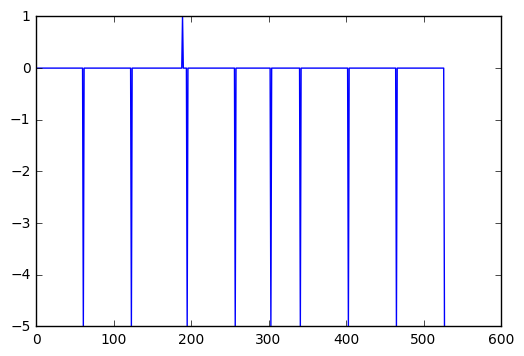

In [6]:
plt.plot(total_rewards)
plt.show()

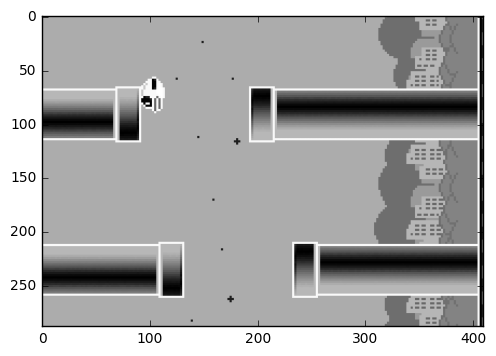

In [7]:
pic = p.getScreenRGB()
plt.imshow(pic[:,:410,1], cmap='Greys')
plt.show()

# policy gradient learner

In [80]:
import tensorflow.contrib.slim as slim

gamma = 0.99

def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

prepro = lambda img : img[:, :410, 1]

class agent():
    def __init__(self, lr, s_size,a_size,h_size):
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        '''hidden = slim.fully_connected(self.state_in,h_size,biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,a_size,activation_fn=tf.nn.softmax,biases_initializer=None)
        self.chosen_action = tf.argmax(self.output,1)
'''
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))
        
tf.reset_default_graph()

myAgent = agent(lr=1e-2,s_size=4,a_size=2,h_size=8)

total_episodes = 100
max_ep = 999
update_frequency = 5

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    i = 0
    total_reward = []
    total_lenght = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    while i < total_episodes:
        s = p.reset_game()
        running_reward = 0
        ep_history = []
        for j in range(max_ep):
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)

            s1,r,d,_ = p.act(a)
            ep_history.append([s,a,r,s1])
            s = s1
            running_reward += r
            if d == True:
                #Update the network.
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                        myAgent.action_holder:ep_history[:,1],myAgent.state_in:np.vstack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        
            #Update our running tally of scores.
        if i % 100 == 0:
            print(np.mean(total_reward[-100:]))
        i += 1

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


ValueError: Cannot feed value of shape (1,) for Tensor 'Placeholder:0', which has shape '(?, 4)'